In [3]:
# 데이터 불러오기 (서울 대기 오염 2019)

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# 폰트 설정 (한글 시각화용)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 불러오기
df = pd.read_excel('서울대기오염_2019.xlsx')

# 2. 컬럼 정리
df.columns = ['날짜', '측정소명', '미세먼지', '초미세먼지', '오존', '이산화질소', '일산화탄소', '아황산가스']

# 3. 날짜 정제
df = df[pd.to_datetime(df['날짜'], errors='coerce').notnull()]
df['날짜'] = pd.to_datetime(df['날짜'])


C:\Users\chlwo\AppData\Local\Temp\ipykernel_429452\1552523701.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = df[pd.to_datetime(df['날짜'], errors='coerce').notnull()]


In [5]:
# 결측치에 대한 평균 값 검증

# 검증 １번、 각 날짜별 측정소 수 카운트
count_by_day = (
    df[df['측정소명'] != '평균']
    .groupby('날짜')['미세먼지']
    .count()
)

# 25개(측정소 수)보다 적은 날만 필터링
dates_with_missing = count_by_day[count_by_day < 25]

print("결측치 있는 날짜 수:", dates_with_missing.shape[0])
print(dates_with_missing.head())

결측치 있는 날짜 수: 85
날짜
2019-07-02    24
2019-07-09    24
2019-07-12    24
2019-07-13    23
2019-07-14    22
Name: 미세먼지, dtype: int64


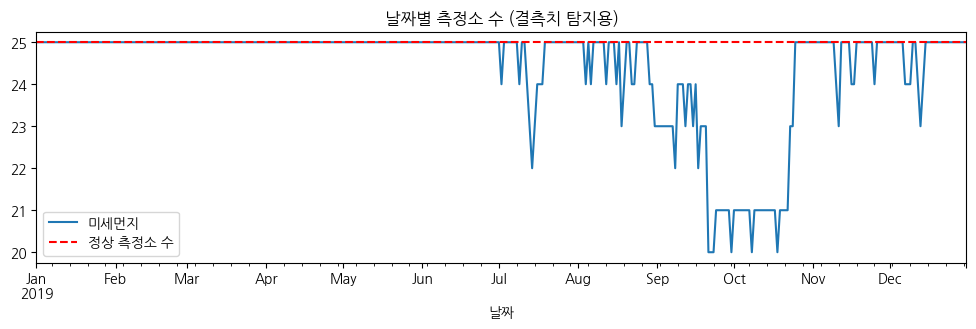

In [6]:
import matplotlib.pyplot as plt

counts = df[df['측정소명'] != '평균'].groupby('날짜')['미세먼지'].count()
counts.plot(figsize=(12, 3), title='날짜별 측정소 수 (결측치 탐지용)')
plt.axhline(25, color='red', linestyle='--', label='정상 측정소 수')
plt.legend()
plt.show()


Text(0.5, 1.0, '측정소별 결측치 Heatmap')

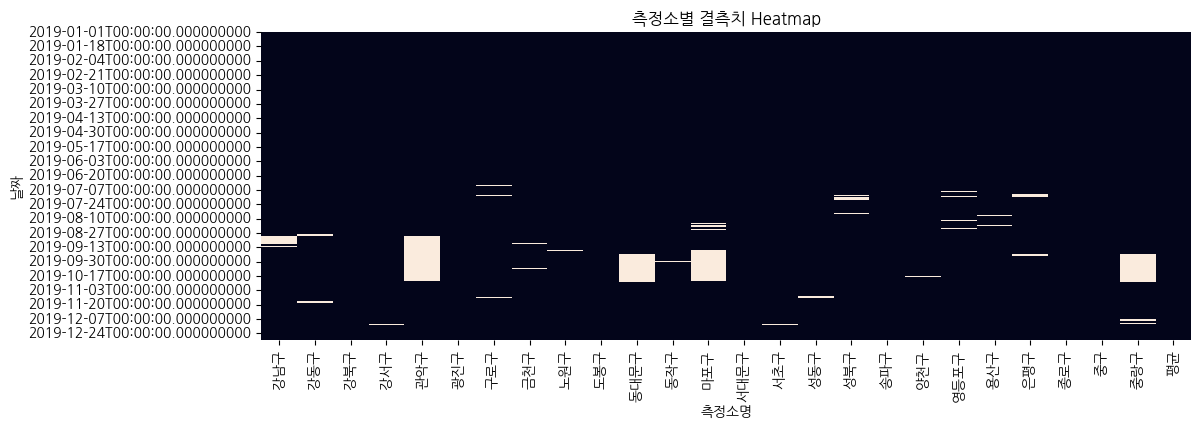

In [7]:
# 시각화 결측치 탐색 시각화 (EDA Heatmap)
import seaborn as sns
plt.figure(figsize=(12, 4))
sns.heatmap(df.pivot_table(index='날짜', columns='측정소명', values='미세먼지').isnull(), cbar=False)
plt.title('측정소별 결측치 Heatmap')

In [8]:
# 파생변수 생성 월 & 요일
df['월'] = df['날짜'].dt.month
df['요일'] = df['날짜'].dt.day_name()


<Axes: title={'center': '요일별 평균 미세먼지'}, xlabel='요일'>

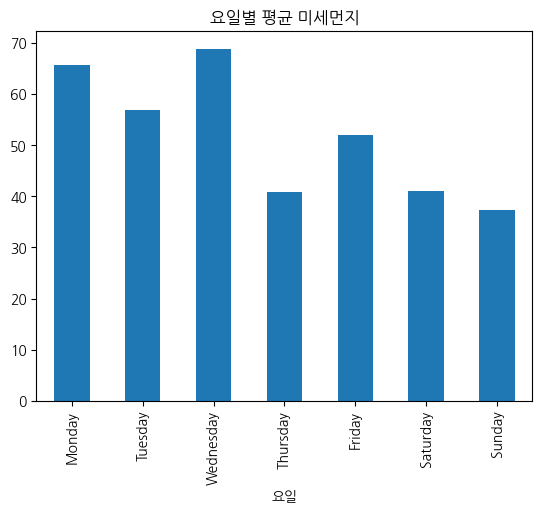

In [9]:
# EDA 월별 / 요일별 분석(Bar plot)
df_monthly = df.groupby('월')['미세먼지'].mean()
df_weekday = df.groupby('요일')['미세먼지'].mean()

df_monthly.plot(kind='bar', title='월별 평균 미세먼지')
df_weekday.loc[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].plot(kind='bar', title='요일별 평균 미세먼지')

C:\Users\chlwo\AppData\Local\Temp\ipykernel_429452\2684439754.py:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  .apply(lambda g: g.interpolate())
C:\Users\chlwo\AppData\Local\Temp\ipykernel_429452\2684439754.py:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  .apply(lambda g: g.interpolate())
C:\Users\chlwo\AppData\Local\Temp\ipykernel_429452\2684439754.py:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  .apply(lambda g: g.interpolate())
C:\Users\chlwo\AppData\Local\Temp\ipykernel_429452\2684439754.py:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. C

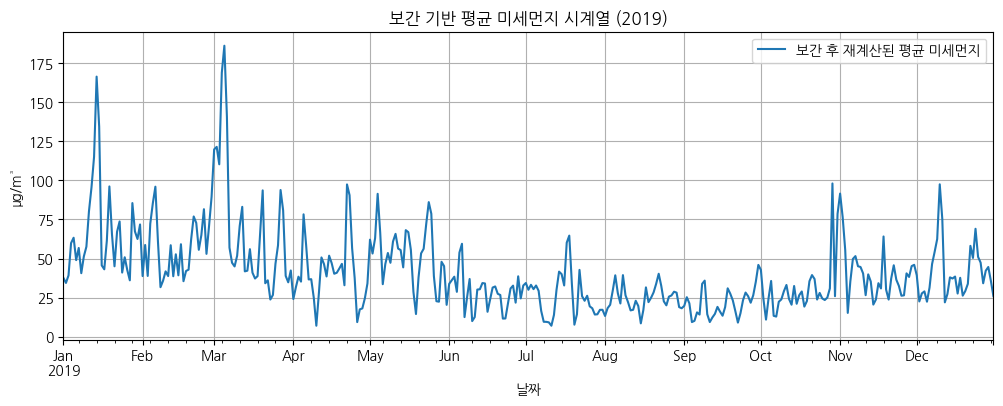

In [10]:
# 2. 날짜 파싱: format 명시하여 경고 제거
df['날짜'] = pd.to_datetime(df['날짜'], format='%Y-%m-%d', errors='coerce')
df = df[df['날짜'].notnull()]

# 3. '측정소명 == 평균' 제거
df = df[df['측정소명'] != '평균'].copy()

# 4. object → numeric으로 자동 변환 (보간 경고 제거)
df = df.infer_objects()

# 5. 정렬 후 보간 (group_keys=False로 향후 호환성 확보)
df.sort_values(['측정소명', '날짜'], inplace=True)
df_interpolated = (
    df.groupby('측정소명', group_keys=False)
    .apply(lambda g: g.interpolate())
    .reset_index(drop=True)
)

# 6. 날짜별 평균 시계열 생성
pm_series = df_interpolated.groupby('날짜')['미세먼지'].mean()

# 7. 시각화
plt.figure(figsize=(12, 4))
pm_series.plot(label='보간 후 재계산된 평균 미세먼지')
plt.title('보간 기반 평균 미세먼지 시계열 (2019)')
plt.ylabel('μg/m³')
plt.xlabel('날짜')
plt.grid()
plt.legend()
plt.show()



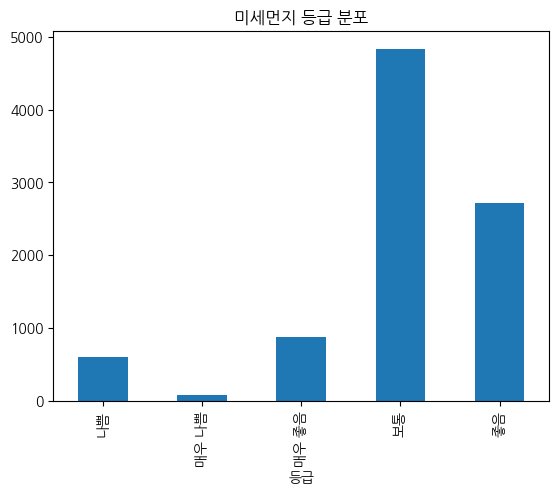

In [11]:
# 미세먼지 등급 분류 함수
def pm_grade(value):
    if value <= 15:
        return '매우 좋음'
    elif value <= 30:
        return '좋음'
    elif value <= 80:
        return '보통'
    elif value <= 150:
        return '나쁨'
    else:
        return '매우 나쁨'

# 미세먼지 등급별 빈도 시각화
df_interpolated['등급'] = df_interpolated['미세먼지'].apply(pm_grade)
df_interpolated['등급'].value_counts().sort_index().plot(kind='bar', title='미세먼지 등급 분포')
plt.show()


Text(0.5, 1.0, '측정소별 미세먼지 분포')

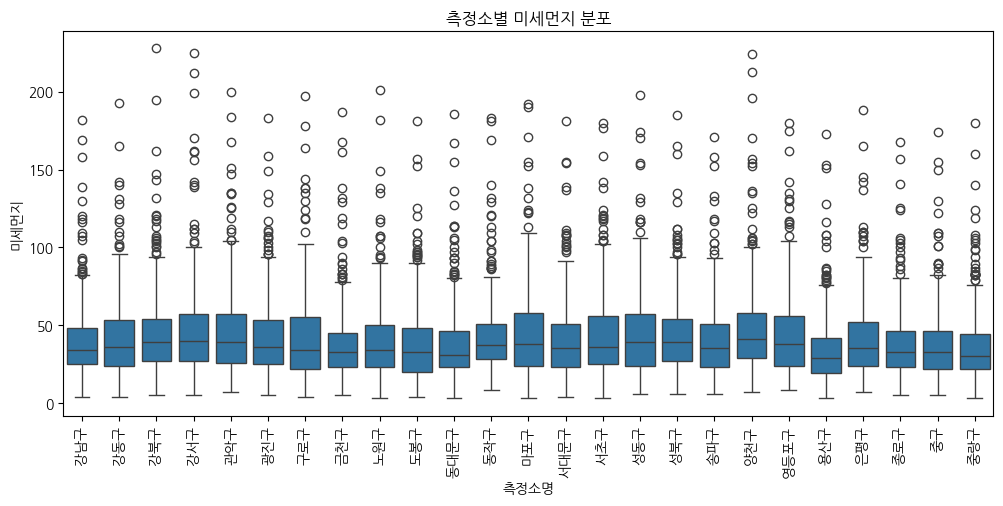

In [12]:
# 측정소별 분포 확인

plt.figure(figsize=(12, 5))
sns.boxplot(x='측정소명', y='미세먼지', data=df_interpolated)
plt.xticks(rotation=90)
plt.title('측정소별 미세먼지 분포')


In [13]:
# 정상성 확인

from statsmodels.tsa.stattools import adfuller

result = adfuller(pm_series)
print("ADF p-value:", result[1])

# ADF p-value: 0.014228288927207528
# 수정 전의 p-value 0.01326704121621125

ADF p-value: 0.014228288927207653


In [14]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA 모델 학습
model = ARIMA(pm_series, order=(1, 1, 1))
model_fit = model.fit()

# 7일 예측
forecast = model_fit.forecast(steps=7)



c:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [15]:
# 예측값 등급화
forecast_grades = forecast.apply(pm_grade)

# DataFrame 생성
forecast_df = pd.DataFrame({
    '예측값': forecast,
    '등급': forecast_grades
})



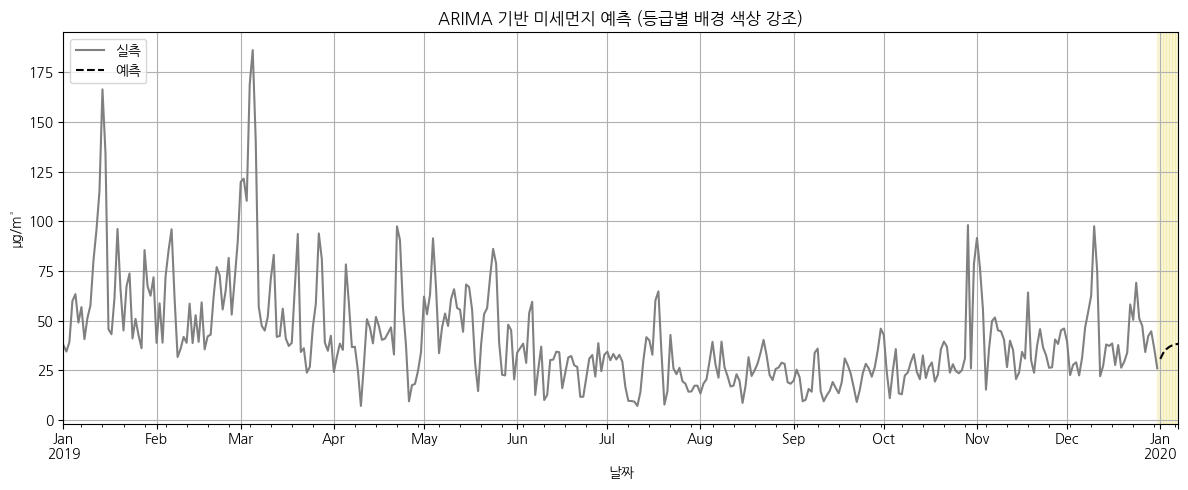

In [16]:
# 1. 배경 색상 정의 (이걸 잊으면 오류 발생)
grade_bg_colors = {
    '매우 좋음': 'darkgreen',
    '좋음': 'lightgreen',
    '보통': 'khaki',
    '나쁨': 'orange',
    '매우 나쁨': 'red'
}

# 2. 시각화 코드 (axvspan 활용)
from datetime import timedelta
plt.figure(figsize=(12, 5))
pm_series.plot(label='실측', color='gray')
forecast.plot(label='예측', color='black', linestyle='--')

for date, grade in zip(forecast_df.index, forecast_df['등급']):
    plt.axvspan(
        date - timedelta(hours=12),
        date + timedelta(hours=12),
        color=grade_bg_colors.get(grade, 'white'),  # 안전하게 get으로 처리
        alpha=0.3
    )

plt.title('ARIMA 기반 미세먼지 예측 (등급별 배경 색상 강조)')
plt.ylabel('μg/m³')
plt.xlabel('날짜')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()



In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1. 학습 데이터 분리 (전체 - 7일)
train = pm_series[:-7]
test = pm_series[-7:]

# 2. 모델 적합
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# 3. 예측
pred = model_fit.forecast(steps=7)

# 4. 평가 지표
rmse = np.sqrt(mean_squared_error(test, pred))
mae = mean_absolute_error(test, pred)

print(f"모델 성능 (Test Set)")
print(f"📉 RMSE: {rmse:.2f}")
print(f"📉 MAE : {mae:.2f}")


모델 성능 (Test Set)
📉 RMSE: 9.68
📉 MAE : 8.03


c:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [18]:
pm_series.to_csv("201906_output.csv", index_label='날짜', header=['평균미세먼지'])